# SEGY handling in julia

[SegyIO.jl](https://github.com/slimgroup/SegyIO.jl) is a Julia package for reading and writing [SEGY Rev 1 files](https://en.wikipedia.org/wiki/SEG-Y). In addition to providing tools for reading/writing entire files, SegyIO provides a parallel scanner that reduces any number of files into a single object with direct out-of-core access to the underlying data.

A video demonstrating the package's capabilities has been made available [here](https://www.youtube.com/watch?v=tx530QOPeZo&feature=youtu.be).

In this tutorial we will show we handle SEGY data in julia:

1. How to read a SEGY file
2. How to scan multiple SEGY files
3. How JUDI interfaces with SegyIO

In [1]:
using JUDI, SegyIO, PyPlot, SlimPlotting

# Data

We consider a subset of the 2007 BP TTI dataset. 

## SegyRead

We first red a single file directly into memory.

This data is a segy container. We can access different headers and the traces:
- `shot.data` contains the traces (in IBMFloat32 format)
- `shot.fileheader` contains the file header
- `shot.traceheader[i]` containts thew trace heaader for the trace numer `i`

In [19]:
shot = segy_read("../data/bpttidata/BPTTI_1289.segy");

┌ Warning: Fixed length trace flag set in stream: IOBuffer(data=UInt8[...], readable=true, writable=false, seekable=true, append=false, size=3878800, maxsize=Inf, ptr=3601, mark=-1)
└ @ SegyIO /opt/julia/1.6.3/local/share/julia/packages/SegyIO/qkvUT/src/read/read_file.jl:26


In [20]:
shot.fileheader

BinaryFileHeader:
                                Job:         0
                               Line:         0
                               Reel:         0
               DataTracePerEnsemble:         0
          AuxiliaryTracePerEnsemble:         0
                                 dt:      8000
                             dtOrig:         0
                                 ns:      1151
                             nsOrig:         0
                   DataSampleFormat:         5
                       EnsembleFold:         0
                       TraceSorting:         0
                    VerticalSumCode:         0
                SweepFrequencyStart:         0
                  SweepFrequencyEnd:         0
                        SweepLength:         0
                          SweepType:         0
                       SweepChannel:         0
              SweepTaperlengthStart:         0
                SweepTaperLengthEnd:         0
                          TaperType:      

In [21]:
shot.traceheaders[10]

BinaryTraceHeader:
                 TraceNumWithinLine:         0
                 TraceNumWithinFile:         0
                        FieldRecord:         0
                        TraceNumber:         0
                  EnergySourcePoint:         0
                                CDP:         0
                           CDPTrace:         0
                        TraceIDCode:         0
                      NSummedTraces:         0
                     NStackedTraces:         0
                            DataUse:         0
                             Offset:         0
                  RecGroupElevation:         0
             SourceSurfaceElevation:         0
                        SourceDepth:         0
                  RecDatumElevation:         0
               SourceDatumElevation:         0
                   SourceWaterDepth:         0
                    GroupWaterDepth:         0
                    ElevationScalar:    -10000
                    RecSourceScalar:    -

We can then easily extra headers from the segy container

In [22]:
sx = get_header(shot, "SourceX")
rx = get_header(shot, :GroupX);
dt = get_header(shot, :dt)[1]*1e-3
T = (get_header(shot, :ns)[1] -1)*dt

9200.0

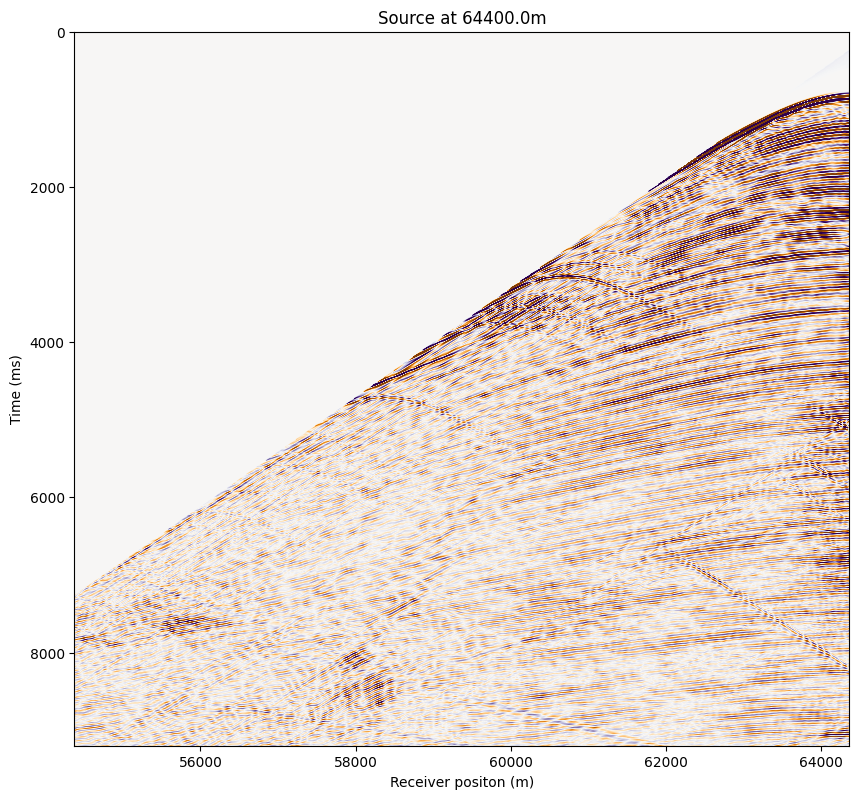

PyObject Text(0.5, 1.0, 'Source at 64400.0m')

In [23]:
extent = [rx[1], rx[end], T, 0]
figure(figsize=(10, 10))
imshow(Float32.(shot.data), vmin=-.5, vmax=.5, cmap="PuOr", interpolation=:hamming, extent=extent)
xlabel("Receiver positon (m)")
ylabel("Time (ms)")
title("Source at $(sx[1])m")

## Segy Scan

The scanner is designed to be multi-scale, meaning that your workflow will stay the same regardless of whether you are working on 1 MB or 1TB of data. SegyIO accomplishes this by being:

  - Direct. Read only what needs to be read.

  - Seamless. Remove the need to deal with complex filesystems.

  - Performant. Read, write, and scan at disk speed.

A scanned volume provides a higher level of abstraction, removing the need for a user to directly manage individual files. Scanning a file (or a group of files) returns a SeisCon object, which contains the necessary information to partition the volume into more managable pieces and directly access these partitions. By default, the scanner will automatically partition the volume when the source location changes.


In [27]:
dir2scan = joinpath(pwd(),"../data/bpttidata/")
file_filter = "BPTTI"

"BPTTI"

We choose wich keys we want to get easy access to after the scan.

In [28]:
keys = ["GroupX", "GroupY", "RecGroupElevation", "SourceSurfaceElevation", "dt"]

5-element Vector{String}:
 "GroupX"
 "GroupY"
 "RecGroupElevation"
 "SourceSurfaceElevation"
 "dt"

In [29]:
segy_lu = segy_scan(dir2scan, file_filter, keys);

Scanning ... /home/jupyter-mlouboutin3@gatech-8972c/julia_tutorials/../data/bpttidata/BPTTI_1200.segy
Scanning ... /home/jupyter-mlouboutin3@gatech-8972c/julia_tutorials/../data/bpttidata/BPTTI_1201.segy
Scanning ... /home/jupyter-mlouboutin3@gatech-8972c/julia_tutorials/../data/bpttidata/BPTTI_1202.segy
Scanning ... /home/jupyter-mlouboutin3@gatech-8972c/julia_tutorials/../data/bpttidata/BPTTI_1203.segy
Scanning ... /home/jupyter-mlouboutin3@gatech-8972c/julia_tutorials/../data/bpttidata/BPTTI_1204.segy
Scanning ... /home/jupyter-mlouboutin3@gatech-8972c/julia_tutorials/../data/bpttidata/BPTTI_1205.segy
Scanning ... /home/jupyter-mlouboutin3@gatech-8972c/julia_tutorials/../data/bpttidata/BPTTI_1206.segy
Scanning ... /home/jupyter-mlouboutin3@gatech-8972c/julia_tutorials/../data/bpttidata/BPTTI_1207.segy
Scanning ... /home/jupyter-mlouboutin3@gatech-8972c/julia_tutorials/../data/bpttidata/BPTTI_1208.segy
Scanning ... /home/jupyter-mlouboutin3@gatech-8972c/julia_tutorials/../data/bpttid

As we can see we found all the segy files in the directory. We know there is 111 shot records let's check the container

In [30]:
length(segy_lu)

111

We scanned correctly the directory for all the shot records. We can now extract global information such as all the source positions

In [31]:
src_locations = get_sources(segy_lu).*1e-4

111×2 Matrix{Float64}:
 59950.0  0.0
 60000.0  0.0
 60050.0  0.0
 60100.0  0.0
 60150.0  0.0
 60200.0  0.0
 60250.0  0.0
 60300.0  0.0
 60350.0  0.0
 60400.0  0.0
 60450.0  0.0
 60500.0  0.0
 60550.0  0.0
     ⋮    
 64900.0  0.0
  6400.0  0.0
  6350.0  0.0
  6300.0  0.0
  6250.0  0.0
  6200.0  0.0
  6150.0  0.0
  6100.0  0.0
  6050.0  0.0
  6000.0  0.0
  5950.0  0.0
   550.0  0.0

# judiVector
Finally, we can wrap the segy container into a judiVector to use it for example for inversion

In [32]:
d_tti = judiVector(segy_lu);

In [33]:
d_tti.nsrc

111

And we can create a source object with unknow wavelet (initialize to a  wavelet in this case)

In [34]:
src_geometry = Geometry(segy_lu; key="source")
wavelet = ricker_wavelet(src_geometry.t[1], src_geometry.dt[1], 0.015)  # 15 Hz peak frequency
q = judiVector(src_geometry, wavelet)

judiVector{Float32, Matrix{Float32}} with 111 sources


In [35]:
shot_id = 47
shot = get_data(d_tti[47])
xrec = shot.geometry.xloc[1]
xsrc = Geometry(q[47].geometry).xloc[1] # convert the out of core geometry to an incore geometry to read the value

1-element Vector{Float32}:
 62250.0

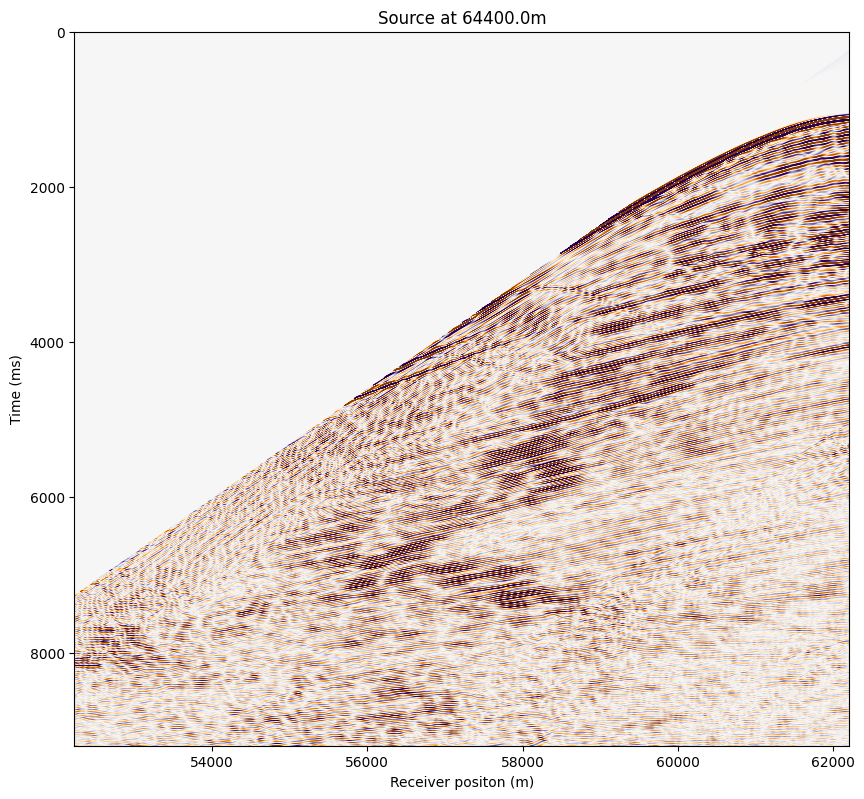

PyObject Text(0.5, 1.0, 'Source at 64400.0m')

In [36]:
extent = [xrec[1], xrec[end], src_geometry.t[1], 0]
figure(figsize=(10, 10))
imshow(shot.data[1], vmin=-.5, vmax=.5, cmap="PuOr", interpolation=:hamming, extent=extent)
xlabel("Receiver positon (m)")
ylabel("Time (ms)")
title("Source at $(sx[1])m")